In [27]:
import pandas as pd
import numpy as np
import networkx as nx
from haversine import haversine
from natsort import natsorted
import cv2
import os


import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
nodes = pd.read_csv('data/Jeju_nodes.csv', encoding='utf-8')
links = pd.read_csv('data/Jeju_links.csv', encoding='cp949')
car = pd.read_csv('data/Jeju_car.csv', encoding='cp949')

nodes = nodes[['Id','NODE_NAME','latitude','longitude']]
links = links[['Source','Target', '시간']]
source_in = links['Source'].apply(lambda x : x in list(nodes['Id'])) # check Sources are in jeju
target_in = links['Target'].apply(lambda x : x in list(nodes['Id'])) # check Targets are in jeju
# source_in and target_in are boolean type pandas.Series which contains True or False
jeju_links = links[source_in & target_in] # contain if both target and source are contained in jeju

In [3]:
G = nx.Graph()

for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])

for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
# make a dictionary for node position


In [4]:
def connectRes(graph, df): # df는 idx, latitude, longitude가 있어야함
    nodes_latitude = nx.get_node_attributes(graph, 'latitude')
    nodes_longitude = nx.get_node_attributes(graph, 'longitude')
    for idx, row in df.iterrows():
        distances ={}
        for keyLong, valLat in nodes_latitude.items():
            nodesPos = (valLat, nodes_longitude[keyLong])
            curPos = (row['latitude'], row['longitude'])
            distances[keyLong] = haversine(nodesPos, curPos, unit='km')
        nearest_node = min(distances, key=distances.get)
        graph.add_node(idx, Label=idx, latitude=row['latitude'], longitude=row['longitude']) ##노드이름은 4050000000이하로 설정
        w = distances[nearest_node]*1000/666 #단위 변환 km->m(*1000), 거리(m)->시간(분) (40km/h = 666m/s)
        graph.add_edge(nearest_node, idx, weight=w) 
    return graph

G = connectRes(G, car)
print(f"Data: {len(car)}, Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")

Data: 31, Nodes: 4249, Edges: 6046


In [5]:
pos = {}
for node in G.nodes(data=True):
    pos[node[0]] = [node[1]['longitude'], node[1]['latitude']]
print(pos)

{4060029000: [126.5127347346484, 33.25467814707047], 4060187801: [126.39331824294078, 33.3024873661656], 4060014200: [126.42782476383329, 33.2404562739723], 4050113000: [126.66792100831752, 33.52942592719583], 4050113700: [126.702717929053, 33.54334954146162], 4050113900: [126.6932062073186, 33.55002376661831], 4060000800: [126.47803908071752, 33.25115167041846], 4060003403: [126.59540181065704, 33.25962426766102], 4060004001: [126.61229309537156, 33.26116974199154], 4060004201: [126.42824562364277, 33.258049186504984], 4060073300: [126.46710231534338, 33.26342101570304], 4060073400: [126.47432673540348, 33.25617183962819], 4060073900: [126.51402343485148, 33.23660747588405], 4060074300: [126.47565173166736, 33.236257363515506], 4060076200: [126.56110683376158, 33.246856539127634], 4050000503: [126.48995924541543, 33.41828117736001], 4050000600: [126.6166982925766, 33.41910314773771], 4050129700: [126.25849982886706, 33.30482457146785], 4050130300: [126.25913909918388, 33.4094155336075

In [9]:
# "G" is a network, "nodelist" is a list of node to select
def draw(G, nodelist=None, select_color = 'red'):
    # plt.figure(figsize= (12, 7))
    plt.cla()
    plt.axis('off')
    nx.draw_networkx(G, pos=pos, node_size = 0, with_labels=False)
    if nodelist != None:
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=select_color, node_size=1)
        edge_colors = [select_color if (u in nodelist and v in nodelist) else 'black' for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    plt.show()

def saveImg(G, nodelist=None, select_color = 'red', name = 'saveImg.png'):
    plt.figure(figsize= (12, 7))
    plt.axis('off')
    nx.draw_networkx(G, pos=pos, node_size = 0, with_labels=False)
    if nodelist != None:
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=select_color, node_size=1)
        edge_colors = [select_color if (u in nodelist and v in nodelist) else 'black' for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    plt.savefig(name)

draw(G)


{4050124800.0: 3.9071372995556852, 4050128900.0: 7.688331712955685, 4050133000.0: 2.000469689555685, 4050081800.0: 4.761554598192177, 4060117000.0: 6.808354238520425, 4050137100.0: 3.7203990079556846, 4060121100.0: 11.981901554520425, 4050141200.0: 3.4588515845556853, 4050145300.0: 9.764863512855685, 24: 0, 4050149400.0: 6.755393002992176, 26: 0, 25: 0, 4050153500.0: 8.333624341992177, 30: 0, 4050157600.0: 11.543494888745391, 4060090400.0: 8.855132502698872, 4060094500.0: 5.78183413684267, 4050161700.0: 6.637686933292176, 4050165800.0: 7.517619454045394, 4050118700.0: 5.344970028598872, 4050122800.0: 7.165015774598872, 4050126900.0: 7.784807444555686, 4060110900.0: 6.554247013720422, 4050131000.0: 3.2144170038556843, 4050135100.0: 2.8052529545556855, 4060119100.0: 9.073598371520424, 4050139200.0: 4.886049596555685, 4050143300.0: 5.777181481992176, 4050147400.0: 3.6010787179921766, 4050151500.0: 10.258373778555686, 4050155600.0: 12.67897699312042, 4060088400.0: 6.546122363842671, 405015

C:\Flutter\bin\ipykernel_27568\3002764857.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors)


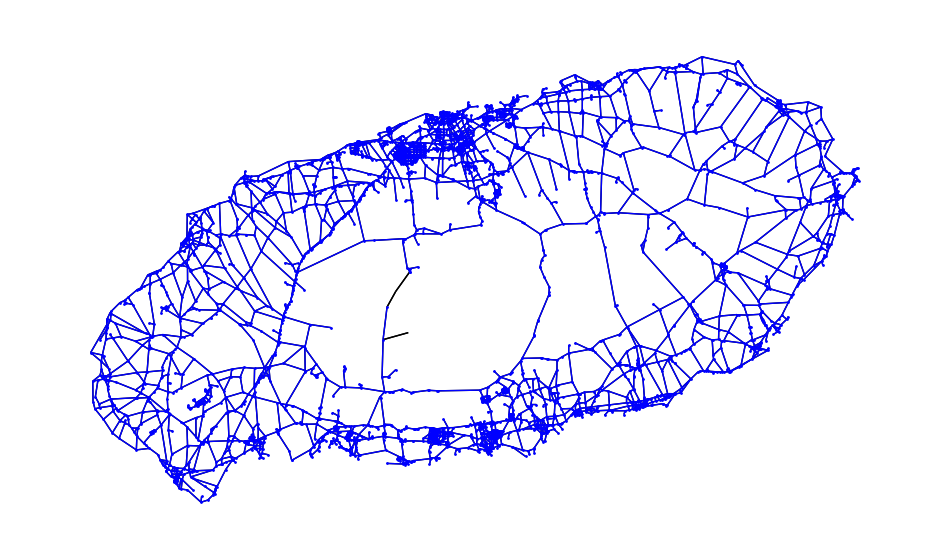

In [7]:
# "G" is network, "start_node" is node_id, "distance" is maximum distance
# return is list of selcted node_id 
def propagation(G, start_node, w = 5):
    shortest_paths = nx.single_source_dijkstra_path_length(G, start_node, cutoff=w, weight='weight')
    # print(f"Start node: {start_node}")
    # print(f"Number of selected Node: {len(shortest_paths)}")
    return shortest_paths

def mergeDict(dict1, dict2):
    result_dict = {}

# Iterate over keys present in both dictionaries
    for key in set(dict1.keys()).intersection(dict2.keys()):
        # Choose the smaller value
        result_dict[key] = min(dict1[key], dict2[key])

    # Add keys from the first dictionary that are not in the second dictionary
    result_dict.update({key: dict1[key] for key in set(dict1.keys()) - set(dict2.keys())})

    # Add keys from the second dictionary that are not in the first dictionary
    result_dict.update({key: dict2[key] for key in set(dict2.keys()) - set(dict1.keys())})

    return result_dict

# serviceArea는 소방서로부터 5분이내 거리에 있는 노드들
serviceArea = {}
for idx, row in car.iterrows():
    tmp = propagation(G, idx, w=25)
    serviceArea = mergeDict(serviceArea, tmp)

print(serviceArea)
print(serviceArea[max(serviceArea, key=serviceArea.get)])
nodesService = list(serviceArea.keys())
draw(G, nodesService, 'blue')

In [ ]:
serviceArea = {}
image_folder = 'propagation'
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

for idx, row in car.iterrows():
    tmp = propagation(G, idx, w=25)
    serviceArea = mergeDict(serviceArea, tmp)

for dist in np.arange(1, 22, 0.5):
    print(f"-----{dist}-----")
    if f"propagation{dist}.png" in images:
        pass
    else:
        nodesService =[]
        for key, value in serviceArea.items():
            if value < dist:
                nodesService.append(key)
        saveImg(G, nodesService, 'red', f"propagation/propagation{dist}.png")

In [42]:
# 이미지 파일들이 저장된 폴더 경로
image_folder = 'propagation'
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

# 이미지 파일들을 정렬
images = natsorted(images)
# 이미지들을 순회하며 연속적으로 보여주기
for image in images:
    img_path = os.path.join(image_folder, image)
    frame = cv2.imread(img_path)
    cv2.imshow('Image', frame)
    cv2.waitKey(500)  # 이미지 간 시간 간격 (100ms)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # 'q' 키를 누르면 종료
        break

cv2.destroyAllWindows()
